<a href="https://colab.research.google.com/github/CSID-DGU/2024-1-CECD1-HexaD-7/blob/feature/HexaD_DataCleanup_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***뉴스 기사 형식 분류를 위한 분류모델 테스팅***

      (1) 적은 데이터로 빠르게 형식 분류 가능성을 테스팅해보기 위해 나이브베이즈 분류모델을 사용하였다.

      (2) 모델학습을 위한 크롤링 데이터의 개수는 각 스트레이트기사 199개,기획기사 199개,보도기사 157개를 사용했다.


      (3) 해당 코드는 크롤링한 기사를 바탕으로한 데이터 전처리 및 분류모델 학습과 테스팅에 대한 코드를 포함한다.

      헬스경향사의 기사 형식별 분류 매칭은 아래 표와 같다.

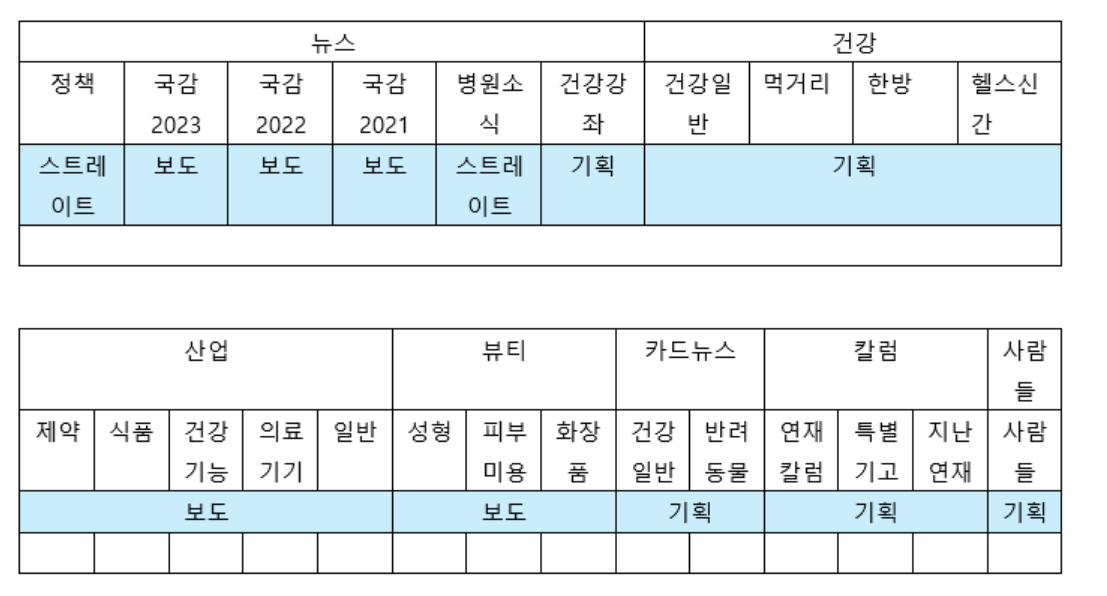

In [66]:
import pandas as pd
import numpy as np
#crawling data 불러오기
#df = pd.read_csv('article_news_policy.csv')
df = pd.read_csv('test.csv', encoding = "CP949", engine='python')

df['Content'].head(500)
df['Tags'].head(500)

# 각 레이블의 개수
tag_counts = df['Tags'].value_counts()
print(tag_counts)


Tags
스트레이트    199
기획       199
보도       157
Name: count, dtype: int64


[크롤링 데이터 전처리 진행]

*   null값 샘플 제거, 중복 데이터 제거
*   한글 외에 데이터 정규표현식 이용하여 전부 제거
*   토큰화 수행
*   불용어 제거





In [31]:
# 정규표현식을 이용해 한글, 숫자 외 문자 제거.
df['Content'] = df['Content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣\d ]", "", regex=True)


print('샘플 개수:', len(df))

#null값을 갖는 튜플 제거
df = df.dropna(subset=['Content'])
print('null값 제거 후 샘플 개수:', len(df))

#중복 기사 제거
df = df.drop_duplicates(subset=['Content'])

print('중복 제거 후 샘플 개수:', len(df))


df['Content'].head(10)

샘플 개수: 2699
null값 제거 후 샘플 개수: 555
중복 제거 후 샘플 개수: 435


0    가천대 길병원은 26일 저스트병원과 진료협력을 위한 협약을 맺었다고 밝혔다 협약식에...
1    가톨릭대 인천성모병원은 오늘29일 이형섭구정순 부부가 병원발전기금 3억원을 기부했다...
2    분당서울대병원은 24일 미국   이하 재단과 미국 로스앤젤레스에 한국형 건강검진센터...
3    서울대치과병원 중앙장애인구강진료센터이하 중앙센터는 제44회 장애인의 날을 맞아 4월...
4    계명대 동산병원은 2025년 2월까지 취약계층 암환자 로봇수술비 지원사업을 시행한다...
5    가톨릭관동대 국제성모병원은 최근 우즈베키스탄 보건부가 병원을 방문했다고 밝혔다 이번...
6    서울대치과병원은 15일부터 23일까지 우즈베키스탄 타슈켄트에서 의료봉사를 마쳤다고 ...
7    대한적십자사 서울특별시지사이하 적십자사 서울지사는 오늘25일부터 28일까지 열리는 ...
8    고려대안암병원이 보건복지부 및 국립암센터 중앙호스피스센터로부터 소아청소년 완화의료 ...
9    서울특별시 서남병원은 최근 열린 제52회 보건의 날 기념식에서 인공관절센터 김영후 ...
Name: Content, dtype: object

[형태소 분석 및 불용어 처리]


*   형태소 기준 토큰화 수행 -> Mecab 사용
*   불용어 처리 수행 -> 토큰화 결과 기반 지속적 불용어 업데이트 필요


In [9]:
!pip install konlpy

In [10]:
!pip install mecab-python3
!pip install unidic-lite # Mecab에 필요한 사전을 설치

In [11]:
!pip install konlpy       # KoNLPy 라이브러리 설치
!apt-get update           # apt-get 업데이트
!apt-get install g++ openjdk-8-jdk python-dev python3-dev # 필수 컴포넌트 설치
!pip3 install JPype1-py3  # JPype1 설치

# Mecab 설치
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

from konlpy.tag import Mecab
mecab = Mecab()


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 1s (168 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-dev is not available, but is referred to by another package.
This may mea

In [32]:
stopwords = ['경향신문','헬스경향','기자','는데','가','등','들','파이낸셜','저작','등','뉴스', '에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재']

In [33]:
#토큰화 및 불용어 제거 수행 함수
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence)
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords]
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [35]:
text_data = preprocessing(df['Content'])
print(text_data[1])


가톨릭 대 인천 성모병원 오늘 29 일 이형섭 구정순 부부 병원 발 전기금 3 억 원 기부 다고 밝혔 병원 이형섭 구정순 부부 감사 를 전하 기 위해 기부금 전달식 열 어 감사패 전달 예우 를 표했 전달식 기부자 이형섭 씨 와 홍승모 몬시뇰 인천 성모 병원장 주요 관계자 참석 이형섭 구정순 부부 지나온 세월 지금 까지 아낌없이 도움 주 셨 던 분 계셨 기 오늘 같이 뜻깊 일 도 었 다며 오늘 결혼기념일 맞이해 우리 부부 작 정성 밀알 되 길 바란다고 밝혔 홍승모 몬시뇰 가톨릭 대 인천 성모 병원장 이형섭 구정순 부부 귀중 마음 깊이 새겨 지역 주민 대표 의료 기관 되 겠 다고 말


[머신러닝 분류모델 적용]



*   나이브베이즈 분류 모델 적용
*   train, test set 비율: train 70%, test 30%



```
# 코드로 형식 지정됨
```



In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [59]:
#train, test data spliting 수행
X = df['Content']
y = df['Tags']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
print('training 뉴스 기사 개수 :', len(X_train))
print('test 뉴스 기사 개수 : ', len(X_test))


training 뉴스 기사 개수 : 304
test 뉴스 기사 개수 :  131


In [60]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [61]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [58]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          기획       0.95      0.99      0.97        76
          보도       1.00      0.95      0.98        64
       스트레이트       0.96      0.96      0.96        78

    accuracy                           0.97       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.97      0.97      0.97       218



In [64]:
#분류 제대로 하는지 테스트(기사 아무거나 긁어와서 레이블 제대로 추측하는가?)
new_sent = preprocessing(["3명의 소중한 생명이 2023년 계묘년의 힘찬 시작을 알렸다. 차 의과대학교 일산 차병원은 1월 1일 0시 정각에 아기 3명이 동시에 탄생했다고 전했다. ▲엄마 김현정씨(40세) 아빠 장동규씨(42) 사이에서 태어난 쌍둥이 여아 짱순이(태명), 남아 짱짱이(태명)와 ▲엄마 손은서씨(30세)와 아빠 김정섭씨(39세) 사이에서 태어난 여아 복동이(태명)다. 특히 올해는 코로나19 이후 3년 만에 처음으로 가족들과 아기의 대면 만남이 이뤄져 더욱 의미가 컸다는 전언이다. 짱짱이·짱순이 엄마 김현정 씨는 “기다렸던 아이들이 건강하게 태어나서 너무 대견하고 기쁘다”며 “아이 아빠는 안타깝게도 코로나19로 오지 못했지만 새해 첫날 많은 사람의 축복 속에서 태어난 우리 쌍둥이들이 건강하고 밝게 자랐으면 한다”고 소감을 말했다. 쌍둥이의 탄생을 지켜본 할머니 정윤자 씨는 “우리 며느리 현정이에게 고생했다고 말해주고 싶고 쌍둥이가 건강하게 자라기를 바란다”고 말했다. 복동이 아빠 김정섭 씨는 “아이가 태어나서 너무 감격스럽고 건강하게 잘 자라기만을 바란다”고 말했다. 일산차병원 산부인과 김의혁 주치의는 “저출산이 심해지는 상황에서 대면으로 소중하고 귀한 아기 탄생을 함께할 수 있어 기쁘다”며 “첫 아기의 탄생과 함께 출산의 기쁨과 생명의 소중함을 새해 첫날 다시 한번 상기하는 시간이 되기를 바란다”고 말했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['스트레이트']
